In [ ]:
from IPython import display
import pandas as pd
import seaborn as sns
from google.cloud import storage
from typing import Any, List, Tuple

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
def get_file_paths_with_prefix(project, bucket_name, prefix):
    storage_client = storage.Client(project)
    blobs = storage_client.list_blobs(bucket_name, prefix=prefix)
    return ['gs://%s/%s' %(bucket_name, blob.name) for blob in blobs]

file_paths = get_file_paths_with_prefix('YOUR_PROJECT', 'antibiotic-combination-images', 'site_images')
print('Number of matching files = %d' % len(file_paths))

Number of matching files = 161279


In [ ]:
def make_image_metadata_df(file_paths, image_extension):
    file_df = pd.DataFrame()
    file_df['path'] = file_paths
    file_df = file_df[file_df['path'].str.endswith(image_extension)]
    
    image_metadata_df = file_df.path.str.extract(r'.*site_images\/(\w*)\-(\d*)-([A-Z])(\d{2})-(\d)-0-(\w*).*TIF')
    image_metadata_df.columns = ['batch', 'plate', 'well_row', 'well_col', 'site', 'stain']
    image_metadata_df['well'] = image_metadata_df['well_row'] + image_metadata_df['well_col']
    image_metadata_df['image_path'] = file_df['path']
    
    # Order columns
    image_metadata_df = image_metadata_df[['batch', 'plate', 'well', 'site', 'stain', 'well_row', 'well_col', 'image_path']]
    
    return image_metadata_df

image_metadata_df = make_image_metadata_df(file_paths, '.TIF')

with pd.option_context('display.max_colwidth', 300):
  display.display(image_metadata_df)

,batch,plate,well,site,stain,well_row,well_col,image_path
0,checker01_______________,5464,A01,1,DAPI,A,01,gs://antibiotic-combination-images/site_images/checker01_______________-5464-A01-1-0-DAPI.TIF
1,checker01_______________,5464,A01,1,FM4_64FX,A,01,gs://antibiotic-combination-images/site_images/checker01_______________-5464-A01-1-0-FM4_64FX.TIF
2,checker01_______________,5464,A01,2,DAPI,A,01,gs://antibiotic-combination-images/site_images/checker01_______________-5464-A01-2-0-DAPI.TIF
3,checker01_______________,5464,A01,2,FM4_64FX,A,01,gs://antibiotic-combination-images/site_images/checker01_______________-5464-A01-2-0-FM4_64FX.TIF
4,checker01_______________,5464,A01,3,DAPI,A,01,gs://antibiotic-combination-images/site_images/checker01_______________-5464-A01-3-0-DAPI.TIF
...,...,...,...,...,...,...,...,...
161274,upload20180801__________,7524,P24,2,FM4_64FX,P,24,gs://antibiotic-combination-images/site_images/upload20180801__________-7524-P24-2-0-FM4_64FX.TIF
161275,upload20180801__________,7524,P24,3,DAPI,P,24,gs://antibiotic-combination-images/site_images/upload20180801__________-7524-P24-3-0-DAPI.TIF
161276,upload20180801__________,7524,P24,3,FM4_64FX,P,24,gs://antibiotic-combination-images/site_images/upload20180801__________-7524-P24-3-0-FM4_64FX.TIF
161277,upload20180801__________,7524,P24,4,DAPI,P,24,gs://antibiotic-combination-images/site_images/upload20180801__________-7524-P24-4-0-DAPI.TIF


In [ ]:
for c in ['batch', 'plate', 'well', 'site', 'stain']:
    print(f'"{c}" unique values are:\n{image_metadata_df[c].unique()}\n')

"batch" unique values are:
['checker01_______________' 'checker02_______________'
 'feng04__________________' 'upload20180620__________'
 'upload20180706_transfer2' 'upload20180801__________']

"plate" unique values are:
['5464' '5481' '6085' '6101' '6102' '6103' '4757' '4877' '6811' '6812'
 '6813' '6831' '6832' '6833' '6834' '6851' '6852' '6853' '6871' '6872'
 '6873' '6874' '6933' '6997' '7102' '7103' '7104' '7121' '7122' '7123'
 '7124' '7141' '7144' '7161' '7166' '7181' '7182' '7201' '7202' '7221'
 '7401' '7402' '7403' '7404' '7421' '7422' '7423' '7424' '7441' '7442'
 '7443' '7444' '7461' '7462' '7463' '7464' '7481' '7482' '7483' '7503'
 '7521' '7522' '7523' '7524']

"well" unique values are:
['A01' 'A02' 'A03' 'A04' 'A05' 'A06' 'A07' 'A08' 'A09' 'A10' 'A11' 'A12'
 'A13' 'A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A21' 'A22' 'A23' 'A24'
 'B01' 'B02' 'B03' 'B04' 'B05' 'B06' 'B07' 'B08' 'B09' 'B10' 'B11' 'B12'
 'B13' 'B14' 'B15' 'B16' 'B17' 'B18' 'B19' 'B20' 'B21' 'B22' 'B23' 'B24'
 'C0

In [ ]:
if image_metadata_df.isna().any().any():
  raise ValueError('There should be no NaNs in image_metadata_df.')

In [ ]:
# Specify how sites are arranged within a well.
site_df = pd.DataFrame(
    columns=pd.Index(['00', '01'], name='site_col'),
    index=pd.Index(['00', '01'], name='site_row'),
    data=[['1', '2'],
          ['3', '4']])
site_df

site_col,00,01
site_row,,
00,1,2
01,3,4


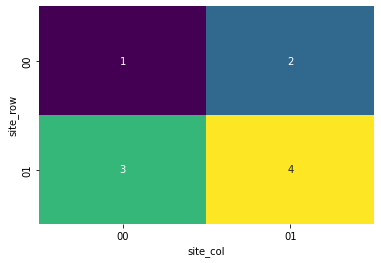

In [ ]:
sns.heatmap(site_df.apply(pd.to_numeric), annot=site_df, fmt='', cmap='viridis', cbar=False);

In [ ]:
def get_missing_column_values(subset: pd.DataFrame, sett: pd.DataFrame,
                              columns: List[str]) -> List[Tuple[Any, ...]]:
    """Returns subset column values that are not in sett column values."""

    subset_tuples = subset[columns].drop_duplicates().apply(tuple, axis='columns')
    set_tuples = sett[columns].apply(tuple, axis='columns')
    column_value_in_set = subset_tuples.isin(set_tuples)

    missing_values = list(subset_tuples[~column_value_in_set])
    return missing_values

def robust_many_to_one_left_join(left: pd.DataFrame, right: pd.DataFrame,
                                 join_cols: List[str]) -> pd.DataFrame:
    # Verify left_df[join_cols] is subset of right_df[join_cols]
    missing_column_values = get_missing_column_values(left, right,
                                                    join_cols)
    if missing_column_values:
        raise ValueError('There were missing join values. missing: %s' %
                         str(missing_column_values))

    # The many_to_one validation asserts that the right_df join values are unique.
    return pd.merge(
        left,
        right,
        how='left',
        on=join_cols,
        suffixes=(None, None),  # Don't create columns if they already exist.
        validate='many_to_one')

def join_site_df(image_metadata_df, site_df):
    long_site_df = pd.melt(site_df, value_name='site', ignore_index=False).reset_index()
    return robust_many_to_one_left_join(image_metadata_df, long_site_df, join_cols=['site'])


full_image_metadata_df = join_site_df(image_metadata_df, site_df)
full_image_metadata_df

,batch,plate,well,site,stain,well_row,well_col,image_path,site_row,site_col
0,checker01_______________,5464,A01,1,DAPI,A,01,gs://antibiotic-combination-images/site_images...,00,00
1,checker01_______________,5464,A01,1,FM4_64FX,A,01,gs://antibiotic-combination-images/site_images...,00,00
2,checker01_______________,5464,A01,2,DAPI,A,01,gs://antibiotic-combination-images/site_images...,00,01
3,checker01_______________,5464,A01,2,FM4_64FX,A,01,gs://antibiotic-combination-images/site_images...,00,01
4,checker01_______________,5464,A01,3,DAPI,A,01,gs://antibiotic-combination-images/site_images...,01,00
...,...,...,...,...,...,...,...,...,...,...
161273,upload20180801__________,7524,P24,2,FM4_64FX,P,24,gs://antibiotic-combination-images/site_images...,00,01
161274,upload20180801__________,7524,P24,3,DAPI,P,24,gs://antibiotic-combination-images/site_images...,01,00
161275,upload20180801__________,7524,P24,3,FM4_64FX,P,24,gs://antibiotic-combination-images/site_images...,01,00
161276,upload20180801__________,7524,P24,4,DAPI,P,24,gs://antibiotic-combination-images/site_images...,01,01


In [ ]:
local_image_metadata_csv_path = 'image_metadata.csv'

with open(local_image_metadata_csv_path, 'w') as f:
    full_image_metadata_df.to_csv(f, header=True, index=False)
# Read it back to inspect that the written csv looks right.
with open(local_image_metadata_csv_path, 'r') as f:
    recovered_df = pd.read_csv(f, dtype=str)
recovered_df

,batch,plate,well,site,stain,well_row,well_col,image_path,site_row,site_col
0,checker01_______________,5464,A01,1,DAPI,A,01,gs://antibiotic-combination-images/site_images...,00,00
1,checker01_______________,5464,A01,1,FM4_64FX,A,01,gs://antibiotic-combination-images/site_images...,00,00
2,checker01_______________,5464,A01,2,DAPI,A,01,gs://antibiotic-combination-images/site_images...,00,01
3,checker01_______________,5464,A01,2,FM4_64FX,A,01,gs://antibiotic-combination-images/site_images...,00,01
4,checker01_______________,5464,A01,3,DAPI,A,01,gs://antibiotic-combination-images/site_images...,01,00
...,...,...,...,...,...,...,...,...,...,...
161273,upload20180801__________,7524,P24,2,FM4_64FX,P,24,gs://antibiotic-combination-images/site_images...,00,01
161274,upload20180801__________,7524,P24,3,DAPI,P,24,gs://antibiotic-combination-images/site_images...,01,00
161275,upload20180801__________,7524,P24,3,FM4_64FX,P,24,gs://antibiotic-combination-images/site_images...,01,00
161276,upload20180801__________,7524,P24,4,DAPI,P,24,gs://antibiotic-combination-images/site_images...,01,01


In [ ]:
gcs_image_metadata_csv_path = 'gs://YOUR_BUCKET/YOUR_PATH/image_metadata.csv'
!gsutil cp {local_image_metadata_csv_path} {gcs_image_metadata_csv_path}